# 1. Import Required Libraries

In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN, BatchNormalization # type: ignore
from tensorflow.keras.optimizers import Adam, RMSprop, SGD # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # type: ignore
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import os
from datetime import datetime
import json
from itertools import product
import optuna
import time

warnings.filterwarnings("ignore")

# 2. Initialize Global Variables and Helper Functions

In [35]:
SEQUENCE_LENGTH = 12
MODEL_DIR = 'clove_models'

#create model directory if it does not exist
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
    print(f"Created model directory: {MODEL_DIR}")

# Initialize preprocessors
scaler_features = StandardScaler()
scaler_target = StandardScaler()
label_encoders = {}

# 3. Data Loading and Preparation Functions

In [36]:
def load_and_prepare_data(data_path):
    """Load and prepare the clove price dataset"""
    # Load data
    print(f"Loading data from {data_path}...")
    df = pd.read_csv(data_path)
    print(f"Initial data shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")

    # Convert Month to datetime
    df['Month'] = pd.to_datetime(df['Month'])

    # Handle missing values in Regional_Price
    missing_before = df['Regional_Price'].isna().sum()
    missing_after = df['Regional_Price'].isna().sum()
    print(f"Missing Regional_Price values: {missing_before} -> {missing_after}")

    # Encode categorical variables
    for col in ['Grade', 'Region']:
        if col not in label_encoders: 
            label_encoders[col] = LabelEncoder()
        df[f'{col}_encoded'] = label_encoders[col].fit_transform(df[col])

    # Create additional time-based features
    df['Year'] = df['Month'].dt.year
    df['Month_num'] = df['Month'].dt.month
    df['Quarter'] = df['Month'].dt.quarter

    print("Creating lag and rolling features...")

    # Create lag features for key variables
    df = df.sort_values(['Grade', 'Region', 'Month'])
    lag_columns = ['Regional_Price', 'National_Price', 'Temperature', 'Rainfall', 'Indonesia_Price_in_USD', 'Madagascar_Price_in_USD', 'Tanzania_Price_in_USD', 'Exchange_Rate', 'Inflation_Rate']
    for col in lag_columns:
        if col in df.columns:
            for lag in [1, 3, 6, 12]:
                df[f'{col}_lag_{lag}'] = df.groupby(['Grade', 'Region'])[col].shift(lag)

    # Create rolling averages
    rolling_columns = ['Regional_Price', 'National_Price', 'Temperature', 'Rainfall', 'Indonesia_Price_in_USD', 'Madagascar_Price_in_USD', 'Tanzania_Price_in_USD', 'Exchange_Rate', 'Inflation_Rate']
    for col in rolling_columns:
        if col in df.columns:
            for window in [3, 6, 12]:
                df[f'{col}_rolling_{window}'] = df.groupby(['Grade', 'Region'])[col].transform(
                    lambda x: x.rolling(window).mean()
                )

    print(f"Final data shape after feature engineering: {df.shape}")
    print(f"Unique grades: {df['Grade'].unique()}")
    print(f"Unique regions: {df['Region'].unique()}")

    return df

# 4. Load Data

In [37]:
DATA_PATH = 'C:/VERGER/Spice_Price_Prediction/Clove/Datasets/Clove_Dataset.csv'
df = load_and_prepare_data(DATA_PATH)
print("\nData loaded successfully!")
print(f"Shape: {df.shape}")
print("\nFirst few rows:")
df.head()
df.info()

Loading data from C:/VERGER/Spice_Price_Prediction/Clove/Datasets/Clove_Dataset.csv...
Initial data shape: (1470, 17)
Columns: ['Month', 'Grade', 'Region', 'Regional_Price', 'National_Price', 'Seasonal_Impact', 'Indonesia_Price_in_USD', 'Madagascar_Price_in_USD', 'Tanzania_Price_in_USD', 'Local_Production_Volume', 'Local_Export_Volume', 'Global_Production_Volume', 'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate', 'Fuel_Price']
Missing Regional_Price values: 0 -> 0
Creating lag and rolling features...
Final data shape after feature engineering: (1470, 85)
Unique grades: ['Clove' 'Stem']
Unique regions: ['Badulla' 'Colombo' 'Galle' 'Gampaha' 'Hambantota' 'Kalutara' 'Kandy'
 'Kegalle' 'Kurunegala' 'Matale' 'Matara' 'Monaragala' 'Nuwaraeliya'
 'Ratnapura']

Data loaded successfully!
Shape: (1470, 85)

First few rows:
<class 'pandas.core.frame.DataFrame'>
Index: 1470 entries, 5 to 1465
Data columns (total 85 columns):
 #   Column                              Non-Null Count  Dtyp

# 5. Price Distribution by Grade

<Figure size 1400x800 with 0 Axes>

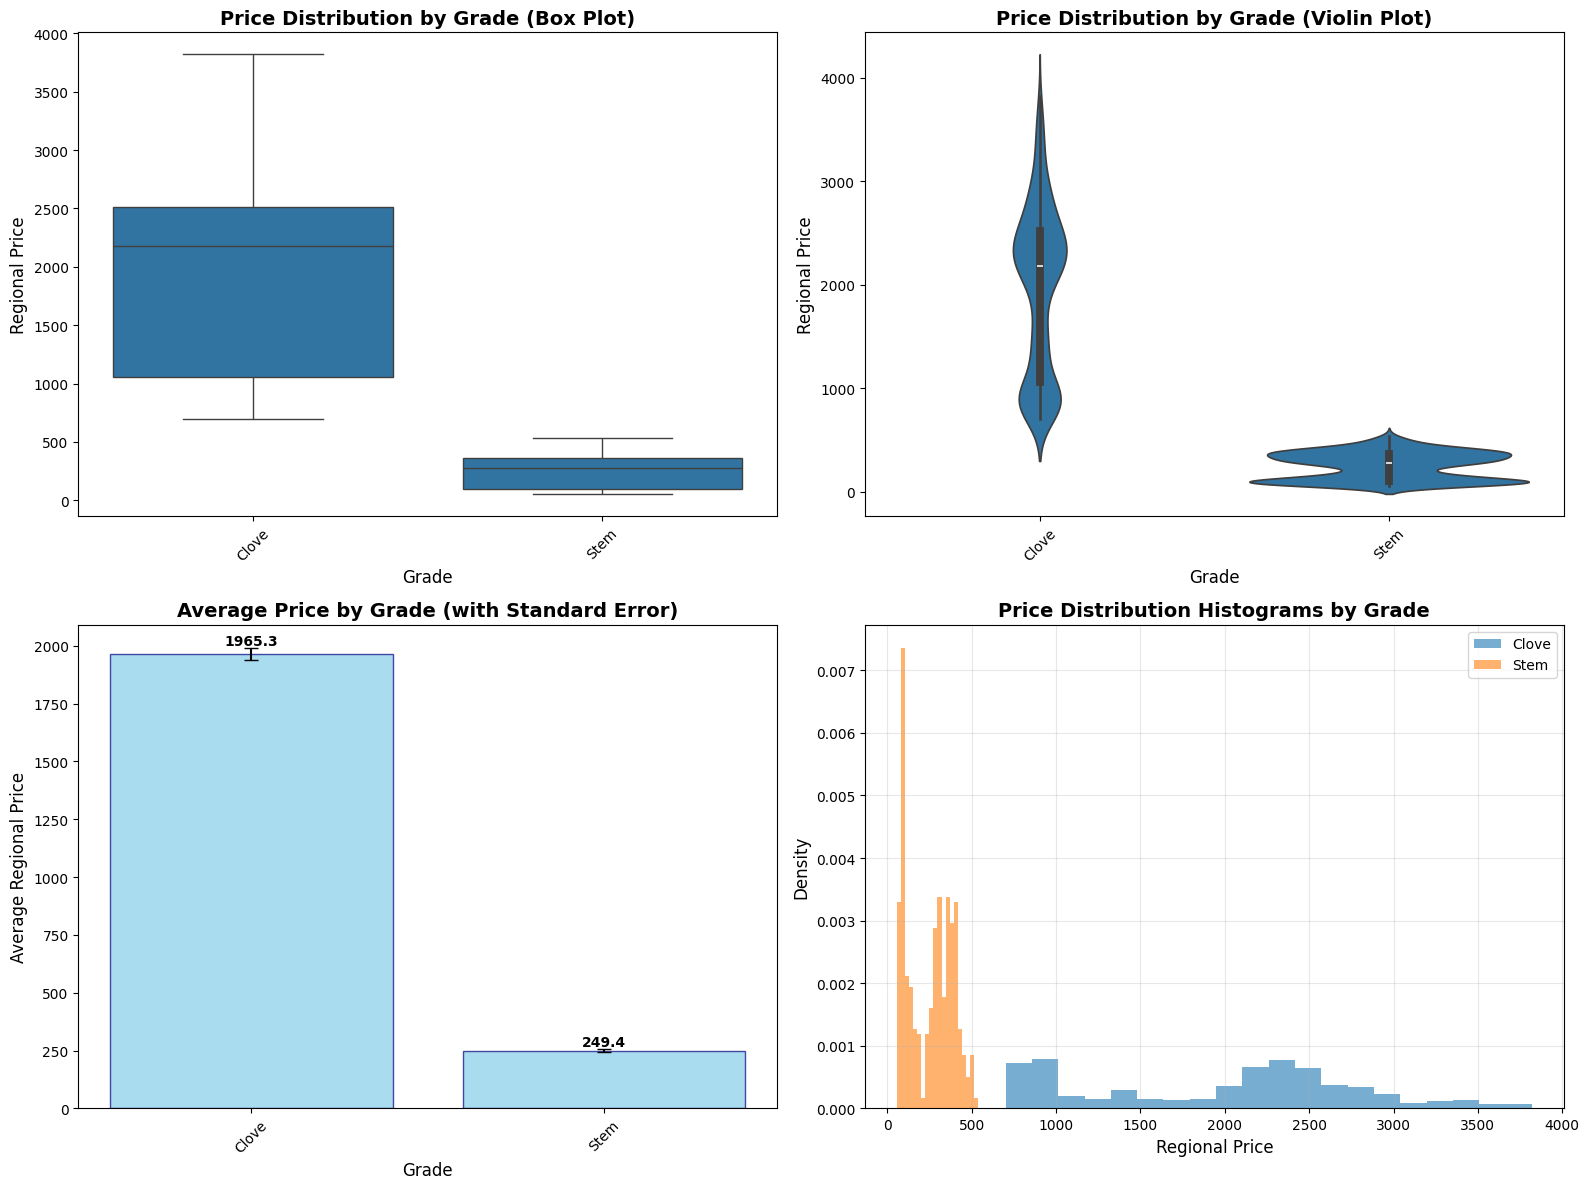


Price Distribution Summary by Grade:
       count     mean     std    min      25%      50%      75%     max
Grade                                                                  
Clove  980.0  1965.32  801.88  700.0  1058.83  2181.62  2514.50  3821.0
Stem   490.0   249.43  133.09   55.0   100.81   279.00   365.75   537.5


In [38]:
def plot_price_distribution_by_grade(df):
    """Plot price distribution by grade"""
    plt.figure(figsize=(14, 8))
    
    # Remove rows with missing Regional_Price
    df_clean = df.dropna(subset=['Regional_Price'])
    
    # Create subplots for different visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Box plot of prices by grade
    sns.boxplot(data=df_clean, x='Grade', y='Regional_Price', ax=ax1)
    ax1.set_title('Price Distribution by Grade (Box Plot)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Grade', fontsize=12)
    ax1.set_ylabel('Regional Price', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Violin plot for detailed distribution
    sns.violinplot(data=df_clean, x='Grade', y='Regional_Price', ax=ax2)
    ax2.set_title('Price Distribution by Grade (Violin Plot)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Grade', fontsize=12)
    ax2.set_ylabel('Regional Price', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Mean prices by grade with error bars
    grade_stats = df_clean.groupby('Grade')['Regional_Price'].agg(['mean', 'std', 'count']).reset_index()
    grade_stats['se'] = grade_stats['std'] / np.sqrt(grade_stats['count'])
    
    ax3.bar(grade_stats['Grade'], grade_stats['mean'], 
            yerr=grade_stats['se'], capsize=5, alpha=0.7, color='skyblue', edgecolor='navy')
    ax3.set_title('Average Price by Grade (with Standard Error)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Grade', fontsize=12)
    ax3.set_ylabel('Average Regional Price', fontsize=12)
    ax3.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for i, (grade, mean_price) in enumerate(zip(grade_stats['Grade'], grade_stats['mean'])):
        ax3.text(i, mean_price + grade_stats['se'].iloc[i], f'{mean_price:.1f}', 
                ha='center', va='bottom', fontweight='bold')
    
    # 4. Histogram of all prices colored by grade
    for grade in df_clean['Grade'].unique():
        grade_data = df_clean[df_clean['Grade'] == grade]['Regional_Price']
        ax4.hist(grade_data, alpha=0.6, label=grade, bins=20, density=True)
    
    ax4.set_title('Price Distribution Histograms by Grade', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Regional Price', fontsize=12)
    ax4.set_ylabel('Density', fontsize=12)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nPrice Distribution Summary by Grade:")
    print("=" * 50)
    summary_stats = df_clean.groupby('Grade')['Regional_Price'].describe()
    print(summary_stats.round(2))

plot_price_distribution_by_grade(df)

# 6. Feature Correlation Matrix

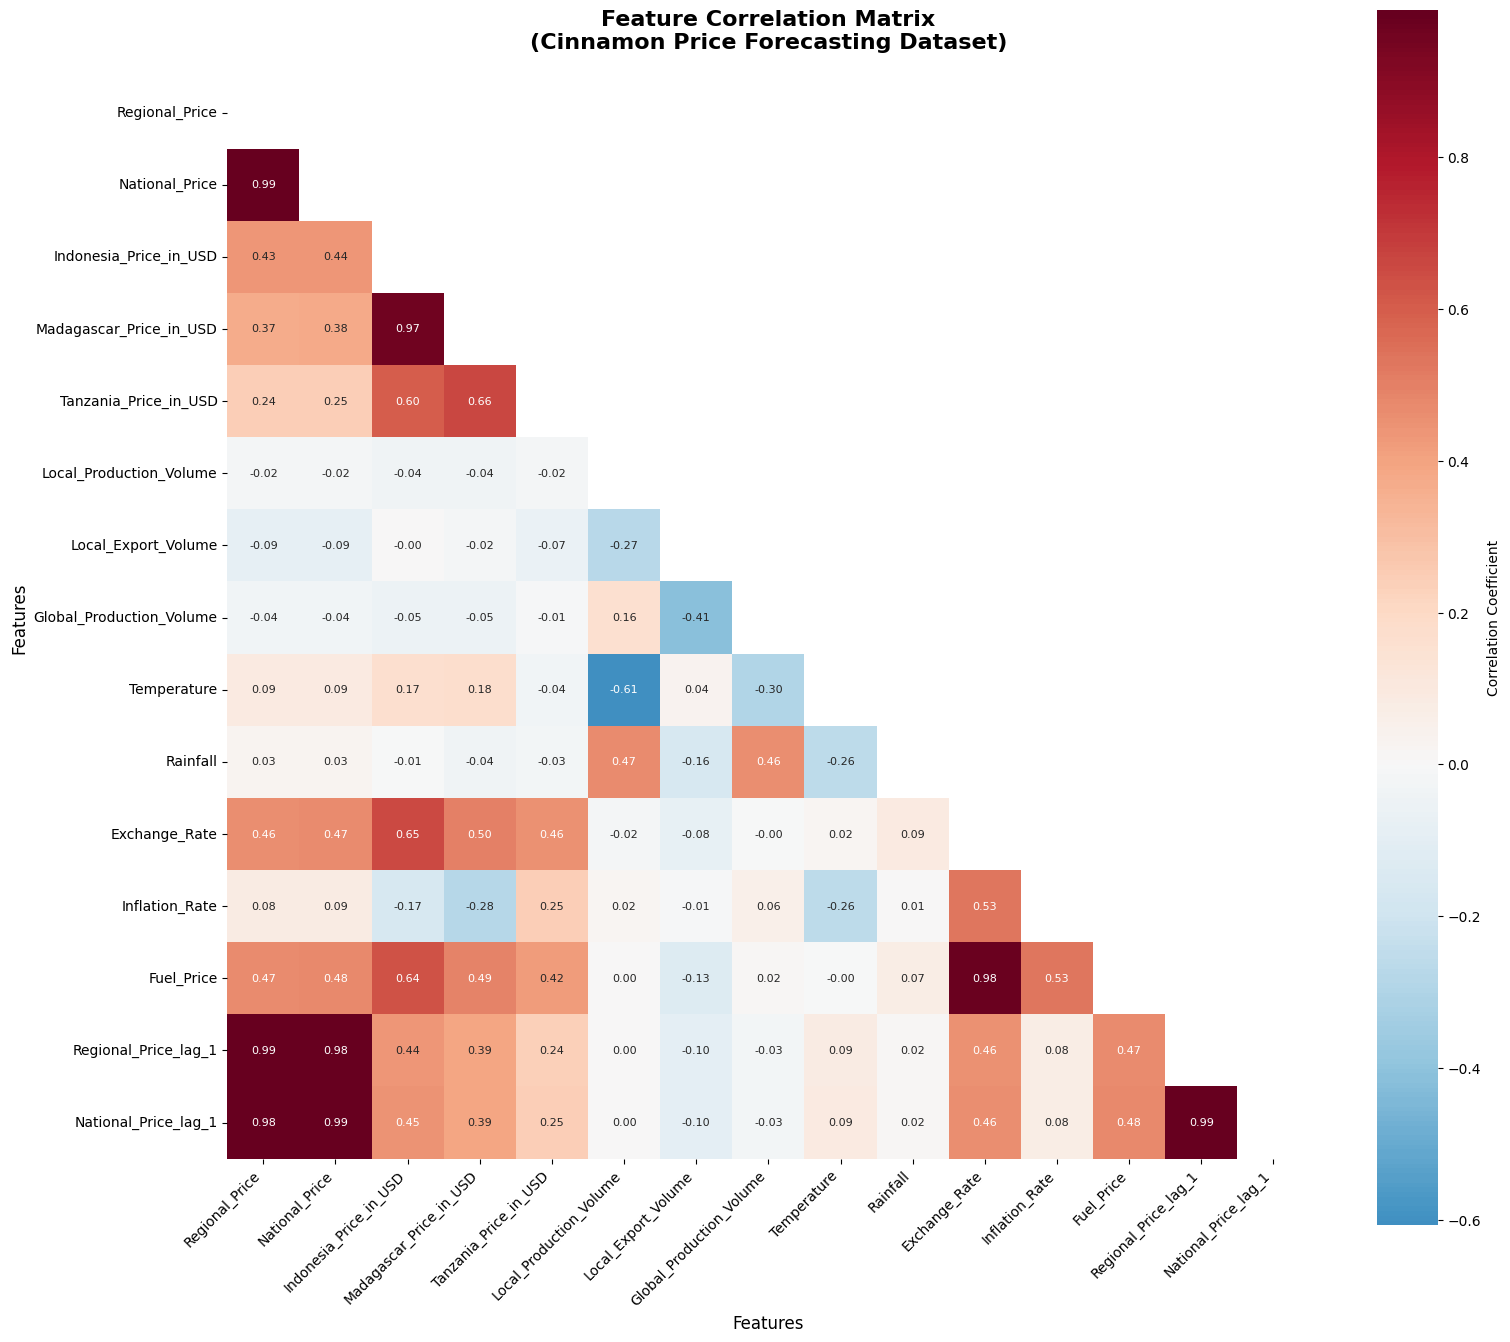


Highly Correlated Feature Pairs (|correlation| > 0.7):
National_Price ↔ National_Price_lag_1: 0.995
Regional_Price ↔ Regional_Price_lag_1: 0.991
Regional_Price ↔ National_Price: 0.989
Regional_Price_lag_1 ↔ National_Price_lag_1: 0.989
Regional_Price ↔ National_Price_lag_1: 0.984
National_Price ↔ Regional_Price_lag_1: 0.984
Exchange_Rate ↔ Fuel_Price: 0.980
Indonesia_Price_in_USD ↔ Madagascar_Price_in_USD: 0.969


In [ ]:
def plot_feature_correlation_matrix(df):
    """Plot feature correlation matrix"""
    # Select numeric features for correlation analysis
    numeric_features = [
    'Regional_Price', 
    'National_Price', 
    'Indonesia_Price_in_USD', 
    'Madagascar_Price_in_USD', 
    'Tanzania_Price_in_USD',
    'Local_Production_Volume',
    'Local_Export_Volume',
    'Global_Production_Volume',
    'Temperature', 
    'Rainfall', 
    'Exchange_Rate', 
    'Inflation_Rate',
    'Fuel_Price',
    'Regional_Price_lag_1',
    'National_Price_lag_1'
]
    
    # Filter to only include columns that exist in the dataframe
    available_features = [col for col in numeric_features if col in df.columns]
    
    # Calculate correlation matrix
    df_numeric = df[available_features].select_dtypes(include=[np.number])
    correlation_matrix = df_numeric.corr()
    
    # Create the plot
    plt.figure(figsize=(16, 14))
    
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Create heatmap
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                fmt='.2f',
                square=True,
                cbar_kws={'label': 'Correlation Coefficient'},
                annot_kws={'size': 8})
    
    plt.title('Feature Correlation Matrix\n(Clove Price Forecasting Dataset)', 
             fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Print highly correlated feature pairs
    print("\nHighly Correlated Feature Pairs (|correlation| > 0.7):")
    print("=" * 60)
    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:
                high_corr_pairs.append((
                    correlation_matrix.columns[i], 
                    correlation_matrix.columns[j], 
                    corr_val
                ))
    
    if high_corr_pairs:
        for feature1, feature2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
            print(f"{feature1} ↔ {feature2}: {corr:.3f}")
    else:
        print("No feature pairs with |correlation| > 0.7 found.")

plot_feature_correlation_matrix(df)

# 7. Sequence Preparation Function for LSTM

In [41]:
def prepare_sequences(df, sequence_length=12, target_col='Regional_Price'):
    """Create sequences for LSTM training"""
    feature_cols = [
        'Grade_encoded', 'Region_encoded',
        'National_Price', 'Seasonal_Impact', 'Local_Production_Volume',
        'Local_Export_Volume', 'Global_Production_Volume',
        'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate', 'Fuel_Price',
        'Year', 'Month_num', 'Quarter'
    ]

    # Add lag and rolling features
    lag_cols = [col for col in df.columns if 'lag_' in col or 'rolling_' in col]
    feature_cols.extend(lag_cols)

    # Instead of dropping all NaNs, fill them
    df_clean = df.copy()
    df_clean = df_clean.fillna(method='bfill').fillna(method='ffill')

    X_sequences, y_sequences, metadata = [], [], []

    for grade in df_clean['Grade'].unique():
        for region in df_clean['Region'].unique():
            subset = df_clean[(df_clean['Grade'] == grade) & (df_clean['Region'] == region)].sort_values('Month')

            if len(subset) < sequence_length + 1:
                continue

            for i in range(len(subset) - sequence_length):
                X_seq = subset.iloc[i:i + sequence_length][feature_cols].values
                y_seq = subset.iloc[i + sequence_length][target_col]

                X_sequences.append(X_seq)
                y_sequences.append(y_seq)
                metadata.append({
                    'grade': grade,
                    'region': region,
                    'date': subset.iloc[i + sequence_length]['Month']
                })

    print("Total sequences created:", len(X_sequences))
    return np.array(X_sequences), np.array(y_sequences), metadata

# 8. LSTM Model Building with Hyperparameter Tuning

In [42]:
def build_lstm_model_tunable(units1=128, units2=64, dropout1=0.2, dropout2=0.2, 
                            dense_units=32, optimizer='adam', learning_rate=0.001, 
                            layer_type='LSTM', use_batch_norm=False, input_shape=None):
    """Build tunable LSTM model with various hyperparameters"""
    model = Sequential()
    
    # Choose layer type
    if layer_type == 'LSTM':
        model.add(LSTM(units1, return_sequences=True, input_shape=input_shape))
    elif layer_type == 'GRU':
        model.add(GRU(units1, return_sequences=True, input_shape=input_shape))
    else:  # SimpleRNN
        model.add(SimpleRNN(units1, return_sequences=True, input_shape=input_shape))
    
    if use_batch_norm:
        model.add(BatchNormalization())
    
    model.add(Dropout(dropout1))
    
    # Second RNN layer
    if layer_type == 'LSTM':
        model.add(LSTM(units2, return_sequences=False))
    elif layer_type == 'GRU':
        model.add(GRU(units2, return_sequences=False))
    else:  # SimpleRNN
        model.add(SimpleRNN(units2, return_sequences=False))
    
    if use_batch_norm:
        model.add(BatchNormalization())
        
    model.add(Dropout(dropout2))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1))
    
    # Configure optimizer
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:  # SGD
        opt = SGD(learning_rate=learning_rate)
    
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    return model

# 9. Define Tuner Class

In [43]:
class HyperparameterTuner:
    """Hyperparameter tuning class using multiple strategies"""
    
    def __init__(self, X_train, y_train, X_val, y_val, input_shape):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.input_shape = input_shape
        self.best_params = None
        self.best_score = float('inf')
        self.tuning_results = []
    
    def grid_search_tuning(self, param_grid=None, max_trials=20):
        """Grid search hyperparameter tuning"""
        print("\n🔍 Starting Grid Search Hyperparameter Tuning...")
        print("=" * 60)
        
        if param_grid is None:
            param_grid = {
                'units1': [64, 128, 256, 512, 1024],
                'units2': [32, 64, 128, 256, 512],
                'dropout1': [0.1, 0.2, 0.3, 0.4, 0.5],
                'dropout2': [0.1, 0.2, 0.3, 0.4, 0.5],
                'dense_units': [16, 32, 64, 128, 256],
                'learning_rate': [0.001, 0.0005, 0.002, 0.005, 0.01],
                'layer_type': ['LSTM', 'GRU'],
                'use_batch_norm': [True, False]
            }
        
        # Generate all combinations and sample randomly if too many
        param_combinations = list(product(*param_grid.values()))
        if len(param_combinations) > max_trials:
            param_combinations = np.random.choice(
                param_combinations, size=max_trials, replace=False
            )
        
        print(f"Testing {len(param_combinations)} parameter combinations...")
        
        best_val_loss = float('inf')
        best_params = None
        
        for i, params in enumerate(param_combinations[:max_trials]):
            param_dict = dict(zip(param_grid.keys(), params))
            
            try:
                print(f"\nTrial {i+1}/{min(len(param_combinations), max_trials)}: {param_dict}")
                
                # Build and train model
                model = build_lstm_model_tunable(**param_dict, input_shape=self.input_shape)
                
                history = model.fit(
                    self.X_train, self.y_train,
                    validation_data=(self.X_val, self.y_val),
                    epochs=30,
                    batch_size=32,
                    verbose=0,
                    callbacks=[
                        EarlyStopping(patience=5, restore_best_weights=True),
                        ReduceLROnPlateau(patience=3, factor=0.5, verbose=0)
                    ]
                )
                
                val_loss = min(history.history['val_loss'])
                
                result = {
                    'trial': i+1,
                    'params': param_dict.copy(),
                    'val_loss': val_loss,
                    'val_mae': min(history.history['val_mae'])
                }
                
                self.tuning_results.append(result)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_params = param_dict.copy()
                    print(f"✅ New best validation loss: {val_loss:.6f}")
                else:
                    print(f"   Validation loss: {val_loss:.6f}")
                
                # Clean up
                del model
                tf.keras.backend.clear_session()
                
            except Exception as e:
                print(f"❌ Trial {i+1} failed: {e}")
                continue
        
        self.best_params = best_params
        self.best_score = best_val_loss
        
        print(f"\n🎉 Grid Search Complete!")
        print(f"Best validation loss: {best_val_loss:.6f}")
        print(f"Best parameters: {best_params}")
        
        return best_params, best_val_loss
    
    def optuna_tuning(self, n_trials=50):
        """Optuna-based hyperparameter tuning"""
        print("\n🎯 Starting Optuna Hyperparameter Tuning...")
        print("=" * 60)
        
        def objective(trial):
            # Define hyperparameter search space
            params = {
                'units1': trial.suggest_categorical('units1', [64, 128, 256, 512]),
                'units2': trial.suggest_categorical('units2', [32, 64, 128, 256]),
                'dropout1': trial.suggest_float('dropout1', 0.1, 0.5, step=0.1),
                'dropout2': trial.suggest_float('dropout2', 0.1, 0.5, step=0.1),
                'dense_units': trial.suggest_categorical('dense_units', [16, 32, 64, 128]),
                'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-2),
                'layer_type': trial.suggest_categorical('layer_type', ['LSTM', 'GRU']),
                'use_batch_norm': trial.suggest_categorical('use_batch_norm', [True, False]),
                'optimizer': trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
            }
            
            try:
                model = build_lstm_model_tunable(**params, input_shape=self.input_shape)
                
                history = model.fit(
                    self.X_train, self.y_train,
                    validation_data=(self.X_val, self.y_val),
                    epochs=25,
                    batch_size=32,
                    verbose=0,
                    callbacks=[
                        EarlyStopping(patience=5, restore_best_weights=True),
                        ReduceLROnPlateau(patience=3, factor=0.5, verbose=0)
                    ]
                )
                
                val_loss = min(history.history['val_loss'])
                
                # Clean up
                del model
                tf.keras.backend.clear_session()
                
                return val_loss
                
            except Exception as e:
                print(f"Trial failed: {e}")
                return float('inf')
        
        # Create study and optimize
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
        
        self.best_params = study.best_params
        self.best_score = study.best_value
        
        print(f"\n🎉 Optuna Tuning Complete!")
        print(f"Best validation loss: {study.best_value:.6f}")
        print(f"Best parameters: {study.best_params}")
        
        # Plot optimization history
        self.plot_optuna_results(study)
        
        return study.best_params, study.best_value
    
    def plot_optuna_results(self, study):
        """Plot Optuna optimization results"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Plot optimization history
        trials = study.trials
        values = [t.value for t in trials if t.value is not None]
        ax1.plot(values, marker='o', alpha=0.7)
        ax1.set_title('Optimization History', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Trial')
        ax1.set_ylabel('Validation Loss')
        ax1.grid(True, alpha=0.3)
        
        # Plot parameter importance
        if len(study.trials) > 10:
            try:
                importance = optuna.importance.get_param_importances(study)
                params = list(importance.keys())
                importances = list(importance.values())
                
                ax2.barh(params, importances)
                ax2.set_title('Parameter Importance', fontsize=14, fontweight='bold')
                ax2.set_xlabel('Importance')
                ax2.grid(True, alpha=0.3)
            except:
                ax2.text(0.5, 0.5, 'Parameter importance\nnot available', 
                        ha='center', va='center', transform=ax2.transAxes)
        
        # Plot best value progression
        best_values = []
        current_best = float('inf')
        for trial in study.trials:
            if trial.value is not None and trial.value < current_best:
                current_best = trial.value
            best_values.append(current_best)
        
        ax3.plot(best_values, marker='o', alpha=0.7, color='green')
        ax3.set_title('Best Value Progression', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Trial')
        ax3.set_ylabel('Best Validation Loss')
        ax3.grid(True, alpha=0.3)
        
        # Distribution of validation losses
        ax4.hist(values, bins=20, alpha=0.7, edgecolor='black')
        ax4.axvline(study.best_value, color='red', linestyle='--', 
                   label=f'Best: {study.best_value:.6f}')
        ax4.set_title('Distribution of Validation Losses', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Validation Loss')
        ax4.set_ylabel('Frequency')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def random_search_tuning(self, n_trials=30):
        """Random search hyperparameter tuning"""
        print("\n🎲 Starting Random Search Hyperparameter Tuning...")
        print("=" * 60)
        
        best_val_loss = float('inf')
        best_params = None
        
        for i in range(n_trials):
            # Randomly sample hyperparameters
            params = {
                'units1': np.random.choice([64, 128, 256, 512]),
                'units2': np.random.choice([32, 64, 128, 256]),
                'dropout1': np.random.uniform(0.1, 0.5),
                'dropout2': np.random.uniform(0.1, 0.5),
                'dense_units': np.random.choice([16, 32, 64, 128]),
                'learning_rate': np.random.loguniform(1e-4, 1e-2),
                'layer_type': np.random.choice(['LSTM', 'GRU']),
                'use_batch_norm': np.random.choice([True, False]),
                'optimizer': np.random.choice(['adam', 'rmsprop'])
            }
            
            try:
                print(f"\nTrial {i+1}/{n_trials}: {params}")
                
                model = build_lstm_model_tunable(**params, input_shape=self.input_shape)
                
                history = model.fit(
                    self.X_train, self.y_train,
                    validation_data=(self.X_val, self.y_val),
                    epochs=25,
                    batch_size=32,
                    verbose=0,
                    callbacks=[
                        EarlyStopping(patience=5, restore_best_weights=True),
                        ReduceLROnPlateau(patience=3, factor=0.5, verbose=0)
                    ]
                )
                
                val_loss = min(history.history['val_loss'])
                
                result = {
                    'trial': i+1,
                    'params': params.copy(),
                    'val_loss': val_loss,
                    'val_mae': min(history.history['val_mae'])
                }
                
                self.tuning_results.append(result)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_params = params.copy()
                    print(f"✅ New best validation loss: {val_loss:.6f}")
                else:
                    print(f"   Validation loss: {val_loss:.6f}")
                
                # Clean up
                del model
                tf.keras.backend.clear_session()
                
            except Exception as e:
                print(f"❌ Trial {i+1} failed: {e}")
                continue
        
        self.best_params = best_params
        self.best_score = best_val_loss
        
        print(f"\n🎉 Random Search Complete!")
        print(f"Best validation loss: {best_val_loss:.6f}")
        print(f"Best parameters: {best_params}")
        
        return best_params, best_val_loss
    
    def plot_tuning_results(self):
        """Plot hyperparameter tuning results"""
        if not self.tuning_results:
            print("No tuning results to plot.")
            return
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Extract data
        trials = [r['trial'] for r in self.tuning_results]
        val_losses = [r['val_loss'] for r in self.tuning_results]
        val_maes = [r['val_mae'] for r in self.tuning_results]
        
        # Plot validation loss progression
        ax1.plot(trials, val_losses, marker='o', alpha=0.7)
        ax1.set_title('Validation Loss by Trial', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Trial')
        ax1.set_ylabel('Validation Loss')
        ax1.grid(True, alpha=0.3)
        
        # Plot validation MAE progression
        ax2.plot(trials, val_maes, marker='s', alpha=0.7, color='orange')
        ax2.set_title('Validation MAE by Trial', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Trial')
        ax2.set_ylabel('Validation MAE')
        ax2.grid(True, alpha=0.3)
        
        # Histogram of validation losses
        ax3.hist(val_losses, bins=15, alpha=0.7, edgecolor='black')
        ax3.axvline(self.best_score, color='red', linestyle='--', 
                   label=f'Best: {self.best_score:.6f}')
        ax3.set_title('Distribution of Validation Losses', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Validation Loss')
        ax3.set_ylabel('Frequency')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Best value progression
        best_so_far = []
        current_best = float('inf')
        for loss in val_losses:
            if loss < current_best:
                current_best = loss
            best_so_far.append(current_best)
        
        ax4.plot(trials, best_so_far, marker='o', alpha=0.7, color='green')
        ax4.set_title('Best Validation Loss Progression', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Trial')
        ax4.set_ylabel('Best Validation Loss')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


# 10. Perform Hyperparameter Tuning

In [44]:
def perform_hyperparameter_tuning(X_train, y_train, X_val, y_val, input_shape, 
                                 method='optuna', n_trials=30):
    """Main function to perform hyperparameter tuning"""
    print(f"\n🚀 Starting Hyperparameter Tuning using {method.upper()} method...")
    
    tuner = HyperparameterTuner(X_train, y_train, X_val, y_val, input_shape)
    
    if method == 'optuna':
        best_params, best_score = tuner.optuna_tuning(n_trials=n_trials)
    elif method == 'random':
        best_params, best_score = tuner.random_search_tuning(n_trials=n_trials)
    else:
        raise ValueError("Method must be 'optuna', 'grid', or 'random'")
    
    # Plot results
    if method in ['grid', 'random']:
        tuner.plot_tuning_results()
    
    return best_params, best_score, tuner

# 11. LSTM Model Building Function

In [45]:
def build_lstm_model(input_shape, best_params=None):
    """Build LSTM model with optional best parameters from tuning"""
    if best_params is None:
        # Default parameters
        best_params = {
            'units1': 128,
            'units2': 64,
            'dropout1': 0.2,
            'dropout2': 0.2,
            'dense_units': 32,
            'optimizer': 'adam',
            'learning_rate': 0.001,
            'layer_type': 'LSTM',
            'use_batch_norm': False
        }
    
    return build_lstm_model_tunable(**best_params, input_shape=input_shape)

# 12. Training History Visualization Function

In [46]:
def plot_training_history(history):
    """Plot training vs validation loss"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot training & validation loss
    ax1.plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
    ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
    ax1.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss (MSE)', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot training & validation MAE
    ax2.plot(history.history['mae'], label='Training MAE', linewidth=2, color='blue')
    ax2.plot(history.history['val_mae'], label='Validation MAE', linewidth=2, color='red')
    ax2.set_title('Model MAE Over Epochs', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('MAE', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_train_mae = history.history['mae'][-1]
    final_val_mae = history.history['val_mae'][-1]
    
    print(f"\nFinal Training Metrics:")
    print(f"Training Loss: {final_train_loss:.4f}")
    print(f"Validation Loss: {final_val_loss:.4f}")
    print(f"Training MAE: {final_train_mae:.4f}")
    print(f"Validation MAE: {final_val_mae:.4f}")

# 13. Model Training Function

In [47]:

def train_model(df, use_tuning=True, tuning_method='optuna', n_tuning_trials=20):
    """Train the forecasting model with optional hyperparameter tuning"""
    global scaler_features, scaler_target
    
    print("Preparing sequences...")
    X, y, metadata = prepare_sequences(df, SEQUENCE_LENGTH)

    if len(X) == 0:
        raise ValueError("No sequences could be created. Check if there's enough data.")

    print(f"Created {len(X)} sequences with shape {X.shape}")

    # Scale features and target
    print("Scaling features...")
    n_samples, n_timesteps, n_features = X.shape
    X_reshaped = X.reshape(-1, n_features)
    X_scaled_reshaped = scaler_features.fit_transform(X_reshaped)
    X_scaled = X_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)

    y_scaled = scaler_target.fit_transform(y.reshape(-1, 1)).flatten()

    # Train-validation-test split
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2 of total
    )

    print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Validation set shape: X={X_val.shape}, y={y_val.shape}")
    print(f"Test set shape: X={X_test.shape}, y={y_test.shape}")

    input_shape = (X_train.shape[1], X_train.shape[2])
    best_params = None
    tuner = None
    
    # Hyperparameter tuning
    if use_tuning:
        print(f"\n🔧 Performing hyperparameter tuning using {tuning_method} method...")
        best_params, best_score, tuner = perform_hyperparameter_tuning(
            X_train, y_train, X_val, y_val, input_shape, 
            method=tuning_method, n_trials=n_tuning_trials
        )
        
        print(f"\n📊 Hyperparameter Tuning Results:")
        print(f"Best validation loss: {best_score:.6f}")
        print(f"Best parameters:")
        for key, value in best_params.items():
            print(f"  {key}: {value}")
    else:
        print("\nSkipping hyperparameter tuning, using default parameters...")

    # Build and train final model with best parameters
    print("\nBuilding final model with optimized parameters...")
    model = build_lstm_model(input_shape, best_params)
    
    # Print model summary
    print("\n📋 Final Model Architecture:")
    model.summary()

    print("\nTraining final model...")
    
    # Use longer training for final model
    final_epochs = 150 if use_tuning else 100
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=final_epochs,
        batch_size=32,
        verbose=1,
        callbacks=[
            EarlyStopping(patience=15, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(patience=8, factor=0.5, verbose=1)
        ]
    )

    # Plot training history
    plot_training_history(history)

    # Evaluate model on test set
    print("\nEvaluating final model on test set...")
    y_pred = model.predict(X_test)
    y_pred_unscaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test_unscaled = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()

    mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
    rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))
    r2 = r2_score(y_test_unscaled, y_pred_unscaled)

    print(f"\n🎯 Final Model Performance on Test Set:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")
    
    # Create comprehensive results dictionary
    results = {
        'mae': mae, 
        'rmse': rmse, 
        'r2': r2,
        'best_params': best_params,
        'tuning_method': tuning_method if use_tuning else None,
        'tuning_used': use_tuning,
        'epochs_trained': len(history.history['loss']),
        'final_train_loss': history.history['loss'][-1],
        'final_val_loss': history.history['val_loss'][-1]
    }
    
    # Add tuning results if available
    if tuner and hasattr(tuner, 'tuning_results'):
        results['tuning_results'] = tuner.tuning_results
    
    return model, history, results

# 14. Train the Model

🚀 STARTING MODEL TRAINING WITH HYPERPARAMETER TUNING
Preparing sequences...


[I 2025-11-12 10:20:04,869] A new study created in memory with name: no-name-1ee47fcc-c6d7-46d5-8113-95364e20f4fd


Total sequences created: 1218
Created 1218 sequences with shape (1218, 12, 78)
Scaling features...
Training set shape: X=(730, 12, 78), y=(730,)
Validation set shape: X=(244, 12, 78), y=(244,)
Test set shape: X=(244, 12, 78), y=(244,)

🔧 Performing hyperparameter tuning using optuna method...

🚀 Starting Hyperparameter Tuning using OPTUNA method...

🎯 Starting Optuna Hyperparameter Tuning...


Best trial: 0. Best value: 0.018535:   2%|▏         | 1/50 [01:19<1:04:52, 79.43s/it]

[I 2025-11-12 10:21:24,301] Trial 0 finished with value: 0.01853497140109539 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.4, 'dropout2': 0.5, 'dense_units': 16, 'learning_rate': 0.0002740691750767259, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 0 with value: 0.01853497140109539.


Best trial: 0. Best value: 0.018535:   4%|▍         | 2/50 [03:15<1:20:57, 101.20s/it]

[I 2025-11-12 10:23:20,741] Trial 1 finished with value: 0.021426334977149963 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.4, 'dropout2': 0.2, 'dense_units': 32, 'learning_rate': 0.0010993817473955634, 'layer_type': 'LSTM', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 0 with value: 0.01853497140109539.


Best trial: 2. Best value: 0.0173227:   6%|▌         | 3/50 [04:23<1:07:06, 85.68s/it] 

[I 2025-11-12 10:24:27,953] Trial 2 finished with value: 0.017322711646556854 and parameters: {'units1': 64, 'units2': 32, 'dropout1': 0.1, 'dropout2': 0.30000000000000004, 'dense_units': 16, 'learning_rate': 0.00017921390208936486, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 2 with value: 0.017322711646556854.


Best trial: 2. Best value: 0.0173227:   8%|▊         | 4/50 [05:22<57:37, 75.17s/it]  

[I 2025-11-12 10:25:26,992] Trial 3 finished with value: 0.019179821014404297 and parameters: {'units1': 128, 'units2': 128, 'dropout1': 0.5, 'dropout2': 0.4, 'dense_units': 128, 'learning_rate': 0.002319202624251578, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 2 with value: 0.017322711646556854.


Best trial: 2. Best value: 0.0173227:  10%|█         | 5/50 [06:44<58:14, 77.66s/it]

[I 2025-11-12 10:26:49,090] Trial 4 finished with value: 0.15422923862934113 and parameters: {'units1': 64, 'units2': 64, 'dropout1': 0.5, 'dropout2': 0.4, 'dense_units': 32, 'learning_rate': 0.0004767261238802433, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 2 with value: 0.017322711646556854.


Best trial: 2. Best value: 0.0173227:  12%|█▏        | 6/50 [07:43<52:15, 71.26s/it]

[I 2025-11-12 10:27:47,934] Trial 5 finished with value: 0.04615117609500885 and parameters: {'units1': 64, 'units2': 32, 'dropout1': 0.30000000000000004, 'dropout2': 0.30000000000000004, 'dense_units': 16, 'learning_rate': 0.00010646447097965743, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 2 with value: 0.017322711646556854.


Best trial: 2. Best value: 0.0173227:  14%|█▍        | 7/50 [08:51<50:19, 70.22s/it]

[I 2025-11-12 10:28:56,004] Trial 6 finished with value: 0.02842233143746853 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.30000000000000004, 'dropout2': 0.4, 'dense_units': 128, 'learning_rate': 0.0016620588470816998, 'layer_type': 'LSTM', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 2 with value: 0.017322711646556854.


Best trial: 2. Best value: 0.0173227:  16%|█▌        | 8/50 [09:54<47:41, 68.13s/it]

[I 2025-11-12 10:29:59,655] Trial 7 finished with value: 0.07147229462862015 and parameters: {'units1': 512, 'units2': 32, 'dropout1': 0.5, 'dropout2': 0.5, 'dense_units': 64, 'learning_rate': 0.004129741326948321, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 2 with value: 0.017322711646556854.


Best trial: 2. Best value: 0.0173227:  18%|█▊        | 9/50 [10:57<45:23, 66.43s/it]

[I 2025-11-12 10:31:02,338] Trial 8 finished with value: 0.020087528973817825 and parameters: {'units1': 512, 'units2': 32, 'dropout1': 0.4, 'dropout2': 0.4, 'dense_units': 64, 'learning_rate': 0.00027175629801038666, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 2 with value: 0.017322711646556854.


Best trial: 9. Best value: 0.0125275:  20%|██        | 10/50 [13:05<57:02, 85.56s/it]

[I 2025-11-12 10:33:10,745] Trial 9 finished with value: 0.012527511455118656 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dense_units': 32, 'learning_rate': 0.0004472427425056024, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 9 with value: 0.012527511455118656.


Best trial: 9. Best value: 0.0125275:  22%|██▏       | 11/50 [16:05<1:14:17, 114.29s/it]

[I 2025-11-12 10:36:10,181] Trial 10 finished with value: 0.01579430140554905 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 32, 'learning_rate': 0.007364044954366673, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 9 with value: 0.012527511455118656.


Best trial: 9. Best value: 0.0125275:  24%|██▍       | 12/50 [19:05<1:25:08, 134.44s/it]

[I 2025-11-12 10:39:10,713] Trial 11 finished with value: 0.020296497270464897 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 32, 'learning_rate': 0.009491824879475775, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 9 with value: 0.012527511455118656.


Best trial: 9. Best value: 0.0125275:  26%|██▌       | 13/50 [22:19<1:33:57, 152.36s/it]

[I 2025-11-12 10:42:24,307] Trial 12 finished with value: 0.020994137972593307 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.1, 'dense_units': 32, 'learning_rate': 0.0007138109320600834, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 9 with value: 0.012527511455118656.


Best trial: 9. Best value: 0.0125275:  28%|██▊       | 14/50 [25:07<1:34:12, 157.02s/it]

[I 2025-11-12 10:45:12,080] Trial 13 finished with value: 0.01992763951420784 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 32, 'learning_rate': 0.0058719445479205835, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 9 with value: 0.012527511455118656.


Best trial: 14. Best value: 0.0114333:  30%|███       | 15/50 [28:48<1:42:49, 176.27s/it]

[I 2025-11-12 10:48:52,963] Trial 14 finished with value: 0.011433347128331661 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 32, 'learning_rate': 0.0005538521660818454, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 14 with value: 0.011433347128331661.


Best trial: 15. Best value: 0.0110928:  32%|███▏      | 16/50 [32:25<1:46:52, 188.59s/it]

[I 2025-11-12 10:52:30,186] Trial 15 finished with value: 0.011092779226601124 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 32, 'learning_rate': 0.0005283383549644487, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.011092779226601124.


Best trial: 15. Best value: 0.0110928:  34%|███▍      | 17/50 [35:27<1:42:36, 186.56s/it]

[I 2025-11-12 10:55:32,008] Trial 16 finished with value: 0.011779452674090862 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 32, 'learning_rate': 0.0008311372320606886, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.011092779226601124.


Best trial: 15. Best value: 0.0110928:  36%|███▌      | 18/50 [38:54<1:42:49, 192.81s/it]

[I 2025-11-12 10:58:59,357] Trial 17 finished with value: 0.011299410834908485 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.0015609967761071157, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.011092779226601124.


Best trial: 15. Best value: 0.0110928:  38%|███▊      | 19/50 [40:16<1:22:27, 159.60s/it]

[I 2025-11-12 11:00:21,609] Trial 18 finished with value: 0.01827414333820343 and parameters: {'units1': 512, 'units2': 64, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.002624011941728049, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.011092779226601124.


Best trial: 15. Best value: 0.0110928:  40%|████      | 20/50 [42:52<1:19:09, 158.33s/it]

[I 2025-11-12 11:02:56,978] Trial 19 finished with value: 0.012311145663261414 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.0016249165668003967, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.011092779226601124.


Best trial: 15. Best value: 0.0110928:  42%|████▏     | 21/50 [46:05<1:21:37, 168.87s/it]

[I 2025-11-12 11:06:10,423] Trial 20 finished with value: 0.011723802424967289 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.4, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.0012150920145367655, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.011092779226601124.


Best trial: 21. Best value: 0.010654:  44%|████▍     | 22/50 [49:26<1:23:20, 178.59s/it] 

[I 2025-11-12 11:09:31,655] Trial 21 finished with value: 0.0106540247797966 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.0004693014656493574, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 21 with value: 0.0106540247797966.


Best trial: 21. Best value: 0.010654:  46%|████▌     | 23/50 [52:42<1:22:39, 183.68s/it]

[I 2025-11-12 11:12:47,224] Trial 22 finished with value: 0.012847674079239368 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dense_units': 64, 'learning_rate': 0.000290297195908422, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 21 with value: 0.0106540247797966.


Best trial: 21. Best value: 0.010654:  48%|████▊     | 24/50 [55:51<1:20:21, 185.46s/it]

[I 2025-11-12 11:15:56,818] Trial 23 finished with value: 0.010678853839635849 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.0006739656888657792, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 21 with value: 0.0106540247797966.


Best trial: 24. Best value: 0.0105507:  50%|█████     | 25/50 [59:13<1:19:19, 190.37s/it]

[I 2025-11-12 11:19:18,661] Trial 24 finished with value: 0.010550704784691334 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.0003681263463894401, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 24 with value: 0.010550704784691334.


Best trial: 25. Best value: 0.0102998:  52%|█████▏    | 26/50 [1:02:36<1:17:40, 194.19s/it]

[I 2025-11-12 11:22:41,762] Trial 25 finished with value: 0.010299834422767162 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.0001957573442137505, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.010299834422767162.


Best trial: 25. Best value: 0.0102998:  54%|█████▍    | 27/50 [1:05:30<1:12:05, 188.06s/it]

[I 2025-11-12 11:25:35,524] Trial 26 finished with value: 0.011730656027793884 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.0001447619852834189, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.010299834422767162.


Best trial: 25. Best value: 0.0102998:  56%|█████▌    | 28/50 [1:07:49<1:03:35, 173.42s/it]

[I 2025-11-12 11:27:54,767] Trial 27 finished with value: 0.011047468520700932 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.00035014981344886633, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.010299834422767162.


Best trial: 25. Best value: 0.0102998:  58%|█████▊    | 29/50 [1:09:29<52:57, 151.29s/it]  

[I 2025-11-12 11:29:34,452] Trial 28 finished with value: 0.011194274760782719 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.00019586424303591604, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.010299834422767162.


Best trial: 25. Best value: 0.0102998:  60%|██████    | 30/50 [1:11:00<44:23, 133.19s/it]

[I 2025-11-12 11:31:05,401] Trial 29 finished with value: 0.01207455713301897 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0002456648609965259, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.010299834422767162.


Best trial: 25. Best value: 0.0102998:  62%|██████▏   | 31/50 [1:13:53<45:58, 145.19s/it]

[I 2025-11-12 11:33:58,580] Trial 30 finished with value: 0.011457782238721848 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.00010487637622222909, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.010299834422767162.


Best trial: 25. Best value: 0.0102998:  64%|██████▍   | 32/50 [1:16:47<46:09, 153.85s/it]

[I 2025-11-12 11:36:52,654] Trial 31 finished with value: 0.011528851464390755 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.0003901332844451593, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.010299834422767162.


Best trial: 25. Best value: 0.0102998:  66%|██████▌   | 33/50 [1:20:03<47:07, 166.34s/it]

[I 2025-11-12 11:40:08,130] Trial 32 finished with value: 0.01133703626692295 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.0006749235243884952, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.010299834422767162.


Best trial: 25. Best value: 0.0102998:  68%|██████▊   | 34/50 [1:23:16<46:32, 174.53s/it]

[I 2025-11-12 11:43:21,769] Trial 33 finished with value: 0.011069080792367458 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.0001921850540333825, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.010299834422767162.


Best trial: 25. Best value: 0.0102998:  70%|███████   | 35/50 [1:25:12<39:13, 156.92s/it]

[I 2025-11-12 11:45:17,579] Trial 34 finished with value: 0.01215860154479742 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'dense_units': 64, 'learning_rate': 0.00100618787175012, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.010299834422767162.


Best trial: 25. Best value: 0.0102998:  72%|███████▏  | 36/50 [1:27:53<36:51, 157.98s/it]

[I 2025-11-12 11:47:58,051] Trial 35 finished with value: 0.011241202242672443 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.0003115206746060821, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 25 with value: 0.010299834422767162.


Best trial: 25. Best value: 0.0102998:  74%|███████▍  | 37/50 [1:28:52<27:47, 128.30s/it]

[I 2025-11-12 11:48:57,094] Trial 36 finished with value: 0.016406472772359848 and parameters: {'units1': 64, 'units2': 32, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0001398062680834776, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.010299834422767162.


Best trial: 25. Best value: 0.0102998:  76%|███████▌  | 38/50 [1:30:38<24:19, 121.62s/it]

[I 2025-11-12 11:50:43,134] Trial 37 finished with value: 0.011945544742047787 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dense_units': 128, 'learning_rate': 0.00021714252286776132, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 25 with value: 0.010299834422767162.


Best trial: 25. Best value: 0.0102998:  78%|███████▊  | 39/50 [1:31:48<19:27, 106.12s/it]

[I 2025-11-12 11:51:53,078] Trial 38 finished with value: 0.03120223432779312 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.0006378781167765704, 'layer_type': 'LSTM', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.010299834422767162.


Best trial: 25. Best value: 0.0102998:  80%|████████  | 40/50 [1:32:43<15:07, 90.76s/it] 

[I 2025-11-12 11:52:48,005] Trial 39 finished with value: 0.020117679610848427 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.30000000000000004, 'dropout2': 0.5, 'dense_units': 16, 'learning_rate': 0.00042888456479686334, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 25 with value: 0.010299834422767162.


Best trial: 25. Best value: 0.0102998:  82%|████████▏ | 41/50 [1:34:39<14:46, 98.50s/it]

[I 2025-11-12 11:54:44,559] Trial 40 finished with value: 0.017128635197877884 and parameters: {'units1': 512, 'units2': 32, 'dropout1': 0.4, 'dropout2': 0.4, 'dense_units': 64, 'learning_rate': 0.00016012893668736309, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.010299834422767162.


Best trial: 25. Best value: 0.0102998:  84%|████████▍ | 42/50 [1:37:13<15:21, 115.21s/it]

[I 2025-11-12 11:57:18,738] Trial 41 finished with value: 0.011818396858870983 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.00036451140864529515, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.010299834422767162.


Best trial: 25. Best value: 0.0102998:  86%|████████▌ | 43/50 [1:39:31<14:14, 122.06s/it]

[I 2025-11-12 11:59:36,805] Trial 42 finished with value: 0.01034690160304308 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.0003458707656808566, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.010299834422767162.


Best trial: 25. Best value: 0.0102998:  88%|████████▊ | 44/50 [1:42:16<13:28, 134.73s/it]

[I 2025-11-12 12:02:21,080] Trial 43 finished with value: 0.010894072242081165 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.0008536166725014548, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.010299834422767162.


Best trial: 25. Best value: 0.0102998:  90%|█████████ | 45/50 [1:45:17<12:23, 148.75s/it]

[I 2025-11-12 12:05:22,565] Trial 44 finished with value: 0.010880808345973492 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.00023653320413619328, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.010299834422767162.


Best trial: 25. Best value: 0.0102998:  92%|█████████▏| 46/50 [1:46:37<08:32, 128.09s/it]

[I 2025-11-12 12:06:42,454] Trial 45 finished with value: 0.02984173223376274 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.0005872741205933999, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 25 with value: 0.010299834422767162.


Best trial: 25. Best value: 0.0102998:  94%|█████████▍| 47/50 [1:49:37<07:10, 143.52s/it]

[I 2025-11-12 12:09:41,978] Trial 46 finished with value: 0.012231018394231796 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.0004586415166195981, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.010299834422767162.


Best trial: 25. Best value: 0.0102998:  96%|█████████▌| 48/50 [1:51:10<04:17, 128.50s/it]

[I 2025-11-12 12:11:15,419] Trial 47 finished with value: 0.014974547550082207 and parameters: {'units1': 256, 'units2': 32, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dense_units': 64, 'learning_rate': 0.0003220263617699424, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.010299834422767162.


Best trial: 25. Best value: 0.0102998:  98%|█████████▊| 49/50 [1:53:36<02:13, 133.64s/it]

[I 2025-11-12 12:13:41,070] Trial 48 finished with value: 0.06154440715909004 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.0001220989570153738, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.010299834422767162.


Best trial: 25. Best value: 0.0102998: 100%|██████████| 50/50 [1:55:51<00:00, 139.03s/it]


[I 2025-11-12 12:15:56,359] Trial 49 finished with value: 0.011336219497025013 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 16, 'learning_rate': 0.001282529156400675, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 25 with value: 0.010299834422767162.

🎉 Optuna Tuning Complete!
Best validation loss: 0.010300
Best parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.0001957573442137505, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}


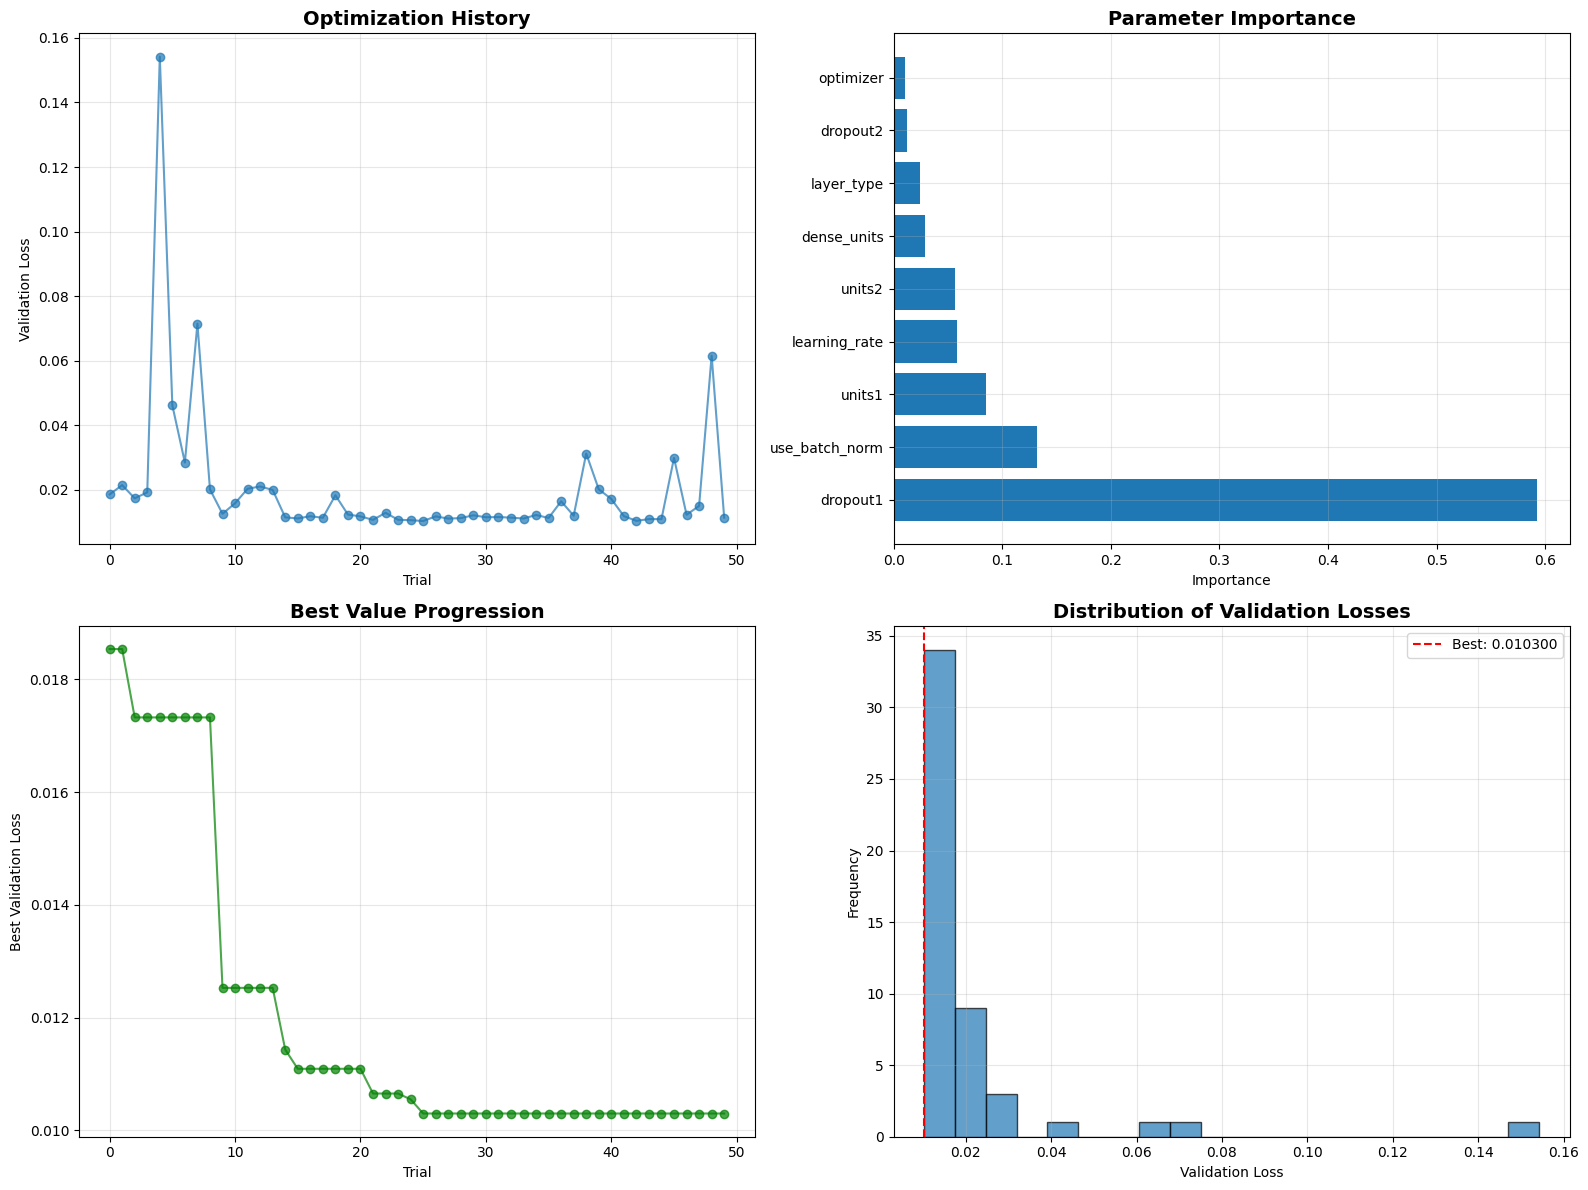


📊 Hyperparameter Tuning Results:
Best validation loss: 0.010300
Best parameters:
  units1: 512
  units2: 256
  dropout1: 0.1
  dropout2: 0.1
  dense_units: 64
  learning_rate: 0.0001957573442137505
  layer_type: GRU
  use_batch_norm: False
  optimizer: rmsprop

Building final model with optimized parameters...

📋 Final Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 12, 512)        │       909,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 256)            │       591,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,517,185 (5.79 MB)

 Trainable params: 1,517,185 (5.79 MB)

 Non-trainable params: 0 (0.00 B)


Training final model...
Epoch 1/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 277ms/step - loss: 0.1431 - mae: 0.2724 - val_loss: 0.0577 - val_mae: 0.1909 - learning_rate: 1.9576e-04
Epoch 2/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 239ms/step - loss: 0.0547 - mae: 0.1818 - val_loss: 0.0645 - val_mae: 0.2108 - learning_rate: 1.9576e-04
Epoch 3/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 253ms/step - loss: 0.0545 - mae: 0.1786 - val_loss: 0.0502 - val_mae: 0.1883 - learning_rate: 1.9576e-04
Epoch 4/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - loss: 0.0396 - mae: 0.1574 - val_loss: 0.0250 - val_mae: 0.1187 - learning_rate: 1.9576e-04
Epoch 5/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - loss: 0.0359 - mae: 0.1474 - val_loss: 0.0562 - val_mae: 0.1894 - learning_rate: 1.9576e-04
Epoch 6/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - loss: 0.0422 - mae: 0.1563 - val_loss: 0.0330 - val_mae: 0.1431 - learning_rate: 1.9576e-04
Epoch 7/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 246ms/step - loss: 0.0306 - mae: 0.1355 - val_loss

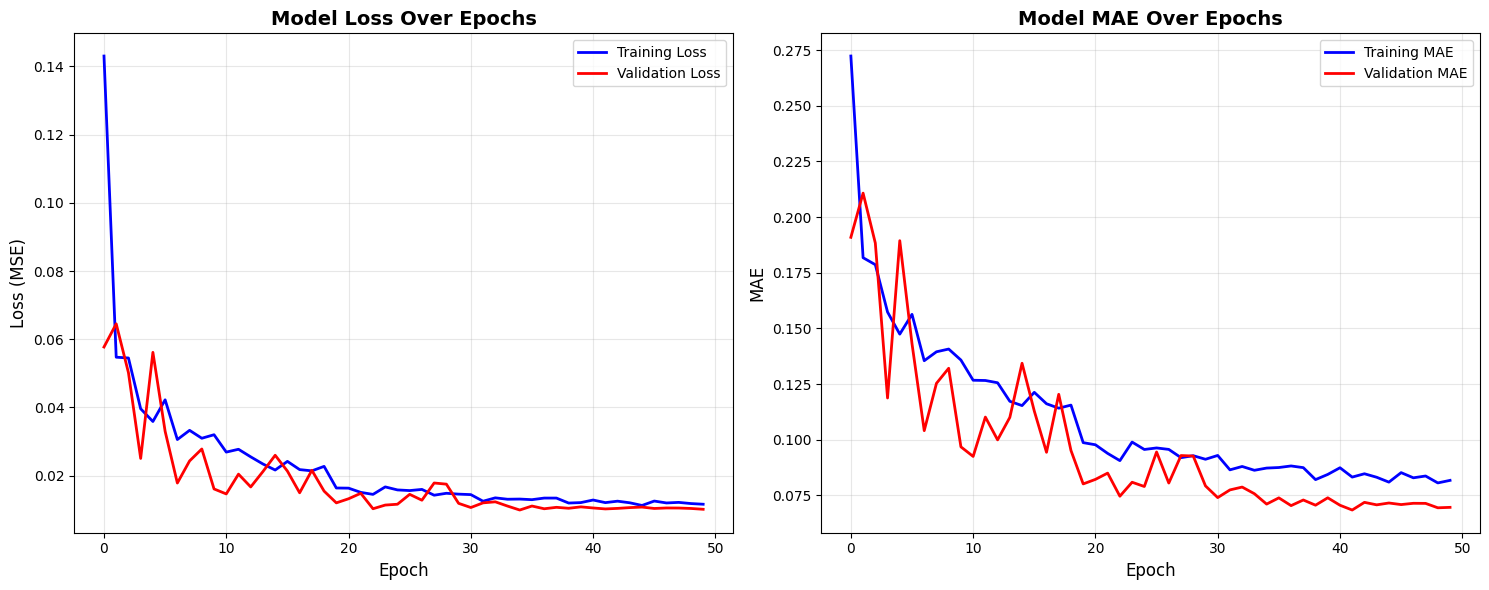


Final Training Metrics:
Training Loss: 0.0116
Validation Loss: 0.0101
Training MAE: 0.0817
Validation MAE: 0.0696

Evaluating final model on test set...
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step

🎯 Final Model Performance on Test Set:
MAE: 93.68
RMSE: 133.92
R²: 0.9832

🎉 Model training completed!


In [48]:
# Train model with hyperparameter tuning
print("🚀 STARTING MODEL TRAINING WITH HYPERPARAMETER TUNING")
print("="*80)

# You can change these parameters:
USE_HYPERPARAMETER_TUNING = True  # Set to False to skip tuning
TUNING_METHOD = 'optuna'  # Options: 'optuna', 'grid', 'random'
N_TUNING_TRIALS = 50  # Number of trials for tuning

model, history, metrics = train_model(
    df, 
    use_tuning=USE_HYPERPARAMETER_TUNING,
    tuning_method=TUNING_METHOD,
    n_tuning_trials=N_TUNING_TRIALS
)

print("\n🎉 Model training completed!")

# 15. Save the Model

In [49]:
def save_model(model, metrics, model_dir=MODEL_DIR):
    """Save the trained model and all preprocessors"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Create model-specific directory
    model_save_dir = os.path.join(model_dir, f"clove_model_{timestamp}")
    os.makedirs(model_save_dir, exist_ok=True)
    
    print(f"\n📁 Saving model to: {model_save_dir}")
    
    try:
        # 1. Save the Keras model
        model_path = os.path.join(model_save_dir, "lstm_model.keras")
        model.save(model_path)
        print(f"✅ Keras model saved: lstm_model.keras")
        
        # 2. Save scalers
        scalers_path = os.path.join(model_save_dir, "scalers.pkl")
        scalers = {
            'scaler_features': scaler_features,
            'scaler_target': scaler_target
        }
        with open(scalers_path, 'wb') as f:
            pickle.dump(scalers, f)
        print(f"✅ Scalers saved: scalers.pkl")
        
        # 3. Save label encoders
        encoders_path = os.path.join(model_save_dir, "label_encoders.pkl")
        with open(encoders_path, 'wb') as f:
            pickle.dump(label_encoders, f)
        print(f"✅ Label encoders saved: label_encoders.pkl")
        
        # 4. Save model configuration and metadata (enhanced with tuning info)
        config = {
            'sequence_length': SEQUENCE_LENGTH,
            'model_architecture': {
                'input_shape': model.input_shape,
                'layers': [str(layer.__class__.__name__) for layer in model.layers],
                'total_params': model.count_params()
            },
            'training_info': {
                'timestamp': timestamp,
                'mae': float(metrics['mae']),
                'rmse': float(metrics['rmse']),
                'r2': float(metrics['r2']),
                'tuning_used': metrics.get('tuning_used', False),
                'tuning_method': metrics.get('tuning_method', None),
                'best_params': metrics.get('best_params', None),
                'epochs_trained': metrics.get('epochs_trained', 0),
                'final_train_loss': float(metrics.get('final_train_loss', 0)),
                'final_val_loss': float(metrics.get('final_val_loss', 0))
            }
        }
        
        # Save tuning results if available
        if 'tuning_results' in metrics and metrics['tuning_results']:
            tuning_results_path = os.path.join(model_save_dir, "tuning_results.json")
            with open(tuning_results_path, 'w') as f:
                json.dump(metrics['tuning_results'], f, indent=2, default=str)
            print(f"✅ Hyperparameter tuning results saved: tuning_results.json")
        
        config_path = os.path.join(model_save_dir, "model_config.json")
        with open(config_path, 'w') as f:
            json.dump(config, f, indent=2, default=str)
        print(f"✅ Model configuration saved: model_config.json")
        
        print(f"\n🎉 Model successfully saved to: {model_save_dir}")
        
        # Print summary of saved model
        print(f"\n📊 Saved Model Summary:")
        print(f"  • Performance: MAE={metrics['mae']:.2f}, RMSE={metrics['rmse']:.2f}, R²={metrics['r2']:.4f}")
        if metrics.get('tuning_used'):
            print(f"  • Hyperparameter tuning: {metrics['tuning_method']} method used")
            print(f"  • Best parameters found and applied")
        print(f"  • Training epochs: {metrics.get('epochs_trained', 'N/A')}")
        print(f"  • Total parameters: {model.count_params():,}")
        
        return model_save_dir
        
    except Exception as e:
        print(f"❌ Error saving model: {str(e)}")
        return None

def load_saved_model(model_path):
    """Load a previously saved model and preprocessors"""
    global scaler_features, scaler_target, label_encoders
    
    print(f"📂 Loading model from: {model_path}")
    
    try:
        # Load the Keras model
        keras_model_path = os.path.join(model_path, "lstm_model.keras")
        model = load_model(keras_model_path)
        print(f"✅ Keras model loaded")
        
        # Load scalers
        scalers_path = os.path.join(model_path, "scalers.pkl")
        with open(scalers_path, 'rb') as f:
            scalers = pickle.load(f)
        scaler_features = scalers['scaler_features']
        scaler_target = scalers['scaler_target']
        print(f"✅ Scalers loaded")
        
        # Load label encoders
        encoders_path = os.path.join(model_path, "label_encoders.pkl")
        with open(encoders_path, 'rb') as f:
            label_encoders = pickle.load(f)
        print(f"✅ Label encoders loaded")
        
        # Load configuration
        config_path = os.path.join(model_path, "model_config.json")
        with open(config_path, 'r') as f:
            config = json.load(f)
        
        print(f"🎉 Model successfully loaded!")
        print(f"📊 Performance: MAE={config['training_info']['mae']:.2f}, "
              f"RMSE={config['training_info']['rmse']:.2f}, "
              f"R²={config['training_info']['r2']:.4f}")
        
        if config['training_info'].get('tuning_used'):
            print(f"🔧 This model was trained with {config['training_info']['tuning_method']} hyperparameter tuning")
        
        return model, config
        
    except Exception as e:
        print(f"❌ Error loading model: {str(e)}")
        return None, None
    
saved_model_path=save_model(model, metrics)
print(f"Model saved at: {saved_model_path}")


📁 Saving model to: clove_models\clove_model_20251112_122212
✅ Keras model saved: lstm_model.keras
✅ Scalers saved: scalers.pkl
✅ Label encoders saved: label_encoders.pkl
✅ Model configuration saved: model_config.json

🎉 Model successfully saved to: clove_models\clove_model_20251112_122212

📊 Saved Model Summary:
  • Performance: MAE=93.68, RMSE=133.92, R²=0.9832
  • Hyperparameter tuning: optuna method used
  • Best parameters found and applied
  • Training epochs: 50
  • Total parameters: 1,517,185
Model saved at: clove_models\clove_model_20251112_122212


# 16. Define Train Features Globally

In [50]:
TRAIN_FEATURE_COLS = [
    'Grade_encoded', 'Region_encoded',
    'Year', 'Month_num', 'Quarter',
    'National_Price', 'Seasonal_Impact',
    'Indonesia_Price_in_USD', 'Madagascar_Price_in_USD', 'Tanzania_Price_in_USD',
    'Local_Production_Volume', 'Local_Export_Volume', 'Global_Production_Volume',
    'Temperature', 'Rainfall',
    'Exchange_Rate', 'Inflation_Rate', 'Fuel_Price',
    'Regional_Price_lag_1', 'Regional_Price_lag_3', 'Regional_Price_lag_6', 'Regional_Price_lag_12',
    'National_Price_lag_1', 'National_Price_lag_3', 'National_Price_lag_6', 'National_Price_lag_12',
    'Indonesia_Price_in_USD_lag_1', 'Indonesia_Price_in_USD_lag_3', 'Indonesia_Price_in_USD_lag_6', 'Indonesia_Price_in_USD_lag_12',
    'Madagascar_Price_in_USD_lag_1', 'Madagascar_Price_in_USD_lag_3', 'Madagascar_Price_in_USD_lag_6', 'Madagascar_Price_in_USD_lag_12',
    'Tanzania_Price_in_USD_lag_1', 'Tanzania_Price_in_USD_lag_3', 'Tanzania_Price_in_USD_lag_6', 'Tanzania_Price_in_USD_lag_12',
    'Temperature_lag_1', 'Temperature_lag_3', 'Temperature_lag_6', 'Temperature_lag_12',
    'Rainfall_lag_1', 'Rainfall_lag_3', 'Rainfall_lag_6', 'Rainfall_lag_12',
    'Exchange_Rate_lag_1', 'Exchange_Rate_lag_3', 'Exchange_Rate_lag_6', 'Exchange_Rate_lag_12',
    'Inflation_Rate_lag_1', 'Inflation_Rate_lag_3', 'Inflation_Rate_lag_6', 'Inflation_Rate_lag_12',
    'Regional_Price_rolling_3', 'Regional_Price_rolling_6', 'Regional_Price_rolling_12',
    'National_Price_rolling_3', 'National_Price_rolling_6', 'National_Price_rolling_12',
    'Indonesia_Price_in_USD_rolling_3', 'Indonesia_Price_in_USD_rolling_6', 'Indonesia_Price_in_USD_rolling_12',
    'Madagascar_Price_in_USD_rolling_3', 'Madagascar_Price_in_USD_rolling_6', 'Madagascar_Price_in_USD_rolling_12',
    'Tanzania_Price_in_USD_rolling_3', 'Tanzania_Price_in_USD_rolling_6', 'Tanzania_Price_in_USD_rolling_12',
    'Temperature_rolling_3', 'Temperature_rolling_6', 'Temperature_rolling_12',
    'Rainfall_rolling_3', 'Rainfall_rolling_6', 'Rainfall_rolling_12',
    'Exchange_Rate_rolling_3', 'Exchange_Rate_rolling_6', 'Exchange_Rate_rolling_12',
    'Inflation_Rate_rolling_3', 'Inflation_Rate_rolling_6', 'Inflation_Rate_rolling_12'
]

# 17. Forecasting Functions

In [51]:
def forecast_prices(model, df, grade, region, months_ahead=12):
    subset = df[(df['Grade'] == grade) & (df['Region'] == region)].sort_values('Month')
    last_row = subset.iloc[-1]
    last_date = last_row['Month']

    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1),
                                 periods=months_ahead, freq='MS')
    
    # Generate future rows
    future_rows = []
    for future_date in future_dates:
        row = last_row.copy()
        row['Month'] = future_date
        row['Year'] = future_date.year
        row['Month_num'] = future_date.month
        row['Quarter'] = future_date.quarter
        row['Temperature'] = last_row['Temperature'] + 2 * np.sin(2*np.pi*(future_date.month-1)/12) + np.random.normal(0,0.5)
        row['Rainfall'] = max(0, last_row['Rainfall'] + 20 * np.sin(2*np.pi*(future_date.month-1)/12) + np.random.normal(0,10))
        row['Exchange_Rate'] = last_row['Exchange_Rate'] * (1 + np.random.normal(0.001,0.005))
        row['Inflation_Rate'] = last_row['Inflation_Rate'] + np.random.normal(0,0.1)
        row['Fuel_Price'] = last_row['Fuel_Price'] * (1 + np.random.normal(0.002,0.02))
        future_rows.append(row)

    future_df = pd.DataFrame(future_rows)
    extended_df = pd.concat([subset, future_df], ignore_index=True).sort_values('Month')

    # Recreate lag and rolling features
    for col in ['Regional_Price','National_Price','Indonesia_Price_in_USD','Tanzania_Price_in_USD','Madagascar_Price_in_USD','Temperature','Rainfall','Exchange_Rate','Inflation_Rate']:
        for lag in [1,3,6,12]:
            extended_df[f'{col}_lag_{lag}'] = extended_df.groupby(['Grade','Region'])[col].shift(lag)
        for window in [3,6,12]:
            extended_df[f'{col}_rolling_{window}'] = extended_df.groupby(['Grade','Region'])[col].transform(lambda x: x.rolling(window).mean())

    # Select exactly the features used during training
    feature_cols = [c for c in TRAIN_FEATURE_COLS if c in extended_df.columns]

    forecasts = []
    historical_data = extended_df[extended_df['Month'] <= last_date]

    for i in range(months_ahead):
        current_data = extended_df.iloc[len(historical_data)-SEQUENCE_LENGTH+i : len(historical_data)+i]
        if len(current_data) < SEQUENCE_LENGTH:
            padding_needed = SEQUENCE_LENGTH - len(current_data)
            last_known = historical_data.iloc[-1:].copy()
            padding_data = pd.concat([last_known]*padding_needed, ignore_index=True)
            current_data = pd.concat([padding_data, current_data], ignore_index=True).iloc[-SEQUENCE_LENGTH:]

        sequence = current_data[feature_cols].ffill().bfill().values
        sequence_flat = sequence.reshape(-1, sequence.shape[-1])
        sequence_scaled_flat = scaler_features.transform(sequence_flat)
        sequence_scaled = sequence_scaled_flat.reshape(sequence.shape)

        next_pred = model.predict(sequence_scaled.reshape(1, SEQUENCE_LENGTH, -1), verbose=0)
        next_pred_unscaled = scaler_target.inverse_transform(next_pred)[0][0]
        forecasts.append(next_pred_unscaled)

        future_idx = len(historical_data)+i
        extended_df.iloc[future_idx, extended_df.columns.get_loc('Regional_Price')] = next_pred_unscaled
        extended_df.iloc[future_idx, extended_df.columns.get_loc('National_Price')] = next_pred_unscaled

    return forecasts, future_dates

# 18. Forecast Visualization Function

In [52]:
def plot_forecast_results(df, model, grade, region, months_ahead=12):
    """Plot 2: Historical data with forecast results"""
    try:
        # Get historical data for the specific grade and region
        subset = df[(df['Grade'] == grade) & (df['Region'] == region)].sort_values('Month')
        
        if len(subset) == 0:
            print(f"No data found for {grade} in {region}")
            return None, None
        
        # Generate forecasts
        forecasts, future_dates = forecast_prices(model, df, grade, region, months_ahead)
        
        # Create the plot
        plt.figure(figsize=(16, 8))
        
        # Plot historical data
        plt.plot(subset['Month'], subset['Regional_Price'], 
                label='Historical Prices', linewidth=2, color='blue', marker='o', markersize=4)
        
        # CREATE BRIDGE: Connect last historical point to first forecast
        last_historical_date = subset['Month'].iloc[-1]
        last_historical_price = subset['Regional_Price'].iloc[-1]
        first_forecast_date = future_dates[0]
        first_forecast_price = forecasts[0]
        
        # Plot the connecting line (bridge)
        plt.plot([last_historical_date, first_forecast_date], 
                [last_historical_price, first_forecast_price], 
                color='orange', linewidth=2, linestyle='-', alpha=0.8, 
                label='Historical-Forecast Bridge')
        
        # Plot forecasts (connected line)
        extended_forecast_dates = [last_historical_date] + list(future_dates)
        extended_forecasts = [last_historical_price] + list(forecasts)
        
        plt.plot(extended_forecast_dates, extended_forecasts, 
                label='Forecasted Prices', linewidth=2, color='red', 
                marker='s', markersize=5, linestyle='--', alpha=0.9)
        
        # Add a vertical line to separate historical and forecasted data
        plt.axvline(x=last_historical_date, color='blue', linestyle=':', alpha=0.5, linewidth=1, 
                   label='Forecast Start')
        
        # Customize the plot
        plt.title(f'Clove Price Forecast: {grade.title()} Grade in {region.title()}\n'
                 f'Historical Data vs {months_ahead}-Month Forecast', 
                 fontsize=16, fontweight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Regional Price', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        
        # Format x-axis dates
        plt.xticks(rotation=45)
        
        # Add confidence bands (simplified approach using standard deviation)
        if len(forecasts) > 1:
            forecast_std = np.std(subset['Regional_Price'].tail(12))  # Use last 12 months std
            upper_bound = np.array(extended_forecasts[1:]) + 1.96 * forecast_std  # Exclude bridge point
            lower_bound = np.array(extended_forecasts[1:]) - 1.96 * forecast_std
            
            plt.fill_between(future_dates, lower_bound, upper_bound, 
                           alpha=0.2, color='red', label='95% Confidence Interval')
        
        plt.tight_layout()
        plt.show()
        
        # Print forecast summary
        print(f"\n{grade.title()} Grade Forecast for {region.title()}:")
        print("=" * 50)
        for i, (date, price) in enumerate(zip(future_dates, forecasts), 1):
            print(f"Month {i:2d} ({date.strftime('%Y-%m')}): LKR.{price:8.2f}")
        
        print(f"\nForecast Statistics:")
        print(f"Average Forecast Price: LKR.{np.mean(forecasts):.2f}")
        print(f"Price Range: LKR.{np.min(forecasts):.2f} - LKR.{np.max(forecasts):.2f}")
        
        # Calculate trend
        if len(forecasts) > 1:
            trend = (forecasts[-1] - forecasts[0]) / len(forecasts)
            trend_direction = "increasing" if trend > 0 else "decreasing"
            print(f"Overall Trend: {trend_direction} by LKR.{abs(trend):.2f} per month")
        
        return forecasts, future_dates
        
    except Exception as e:
        print(f"Error plotting forecast results: {e}")
        import traceback
        traceback.print_exc()
        return None, None